# Essentials Notebook
This notebook provides most important and must have tools for early stage analysis.
It allows to quickly verify reward function and identify potential problems.

Analysis is divided into 2 sections:
- Vehicle Behaviour
- Reward Properties

There are few code explanations, because it is assumed, that you have already visited *Training_analysis* notebook and have some knowledge about parameters described here. Non standard implementations are documented.

## Import modules

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from deepracer.tracks import TrackIO, Track
from deepracer.logs import CloudWatchLogs as cw, \
    SimulationLogsIO as slio, \
    AnalysisUtils as au, \
    PlottingUtils as pu

## Load track

In [2]:
!ls tracks/

AmericasGeneratedInclStart.npy	New_York_Eval_Track.npy
AWS_track.npy			New_York_Track.npy
Bowtie_track.npy		Oval_track.npy
Canada_Eval.npy			reInvent2019_track.npy
Canada_Training.npy		reInvent2019_wide_mirrored.npy
China_eval_track.npy		reInvent2019_wide.npy
China_track.npy			reinvent_base.npy
H_track.npy			Spain_track.npy
LGSWide.npy			Straight_track.npy
London_Loop_Train.npy		Tokyo_Training_track.npy
Mexico_track_eval.npy		Vegas_track.npy
Mexico_track.npy		Virtual_May19_Train_track.npy


In [3]:
tu = TrackIO()

In [4]:
track = tu.load_track("Spain_track")

Loaded 259 waypoints


## Load log

In [169]:
stream_name = 'sim-xy4rydwzs0c3' ## CHANGE This to your simulation application ID
fname = 'logs/deepracer-%s.log' %stream_name  # The log will be downloaded into the specified path

In [170]:
cw.download_log(fname, stream_prefix=stream_name)  # add force=True if you downloaded the file before but want to repeat

Log file exists, use force=True to download again


In [172]:
EPISODES_PER_ITERATION = 50 #  Set to value of your hyperparameter in training

data = slio.load_data(fname)
df = slio.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)

df = df.sort_values(['episode', 'steps'])

In [173]:
df

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp
0,1,0,3,0.1811,-2.1730,-179.9510,-16.0,1.6,1.0,3.9982,0,True,0.2778,1,60.0,1590670829.0807228
1,1,0,4,0.1540,-2.1723,179.7851,16.0,1.6,5.0,3.9915,0,True,0.3229,1,60.0,1590670829.1470368
2,1,0,5,0.1014,-2.1711,179.4354,-8.0,1.7,2.0,3.9772,0,True,0.4105,1,60.0,1590670829.2141378
3,1,0,6,0.0431,-2.1700,179.2717,8.0,1.7,4.0,3.9694,0,True,0.5078,1,60.0,1590670829.2854016
4,1,0,7,-0.0378,-2.1680,178.9290,-8.0,1.7,2.0,3.9539,0,True,0.6426,1,60.0,1590670829.3540578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63576,11,519,201,-2.1468,3.0259,-68.9500,0.0,1.8,3.0,1.9703,0,True,38.1365,82,60.0,1590677909.831747
63577,11,519,202,-2.0973,2.8950,-69.1660,8.0,1.7,4.0,0.1643,0,False,38.2819,82,60.0,1590677909.8893452
63578,11,519,203,-2.0624,2.8045,-69.0250,8.0,1.7,4.0,0.1563,0,False,38.4006,83,60.0,1590677909.9639847
63579,11,519,204,-2.0058,2.6627,-68.4657,16.0,1.6,5.0,0.1241,0,False,38.4783,83,60.0,1590677910.02533


# Vehicle Behaviour
## Action distribution
More even the distribution is the better the action space is matched with the track. Also can detect not used actions.

In [174]:
df['action'].value_counts().sort_index()

0.0    13427
1.0    13719
2.0     9889
3.0     5098
4.0     4486
5.0    10056
6.0     6906
Name: action, dtype: int64

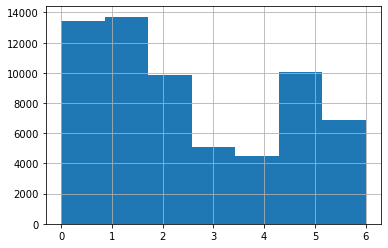

In [175]:
df['action'].hist(bins=int(df['action'].max() + 1))

-16.0    13719
-30.0    13427
 16.0    10056
-8.0      9889
 30.0     6906
 0.0      5098
 8.0      4486
Name: steer, dtype: int64

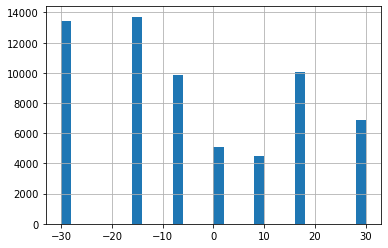

In [176]:
df['steer'].hist(bins=30)
df['steer'].value_counts()

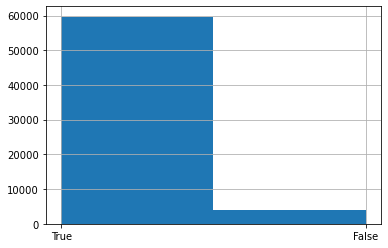

In [177]:
df['on_track'].hist(bins=2)

In [178]:
# once cmap support for pu.plot_track is added, plot steering around the track
#pu.plot_track(df, track, value_field='steer', margin=1, cmap='bwr')

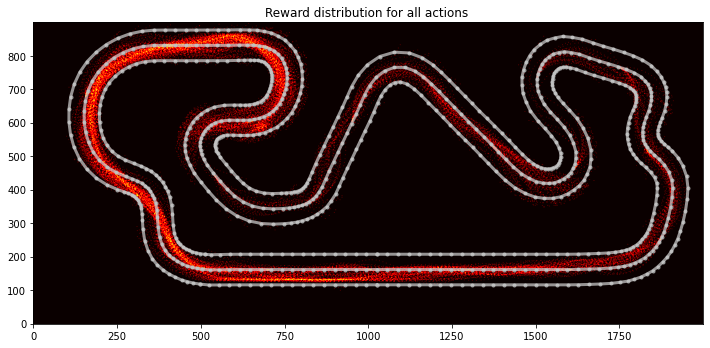

<Figure size 432x288 with 0 Axes>

In [179]:
pu.plot_track(df, track, value_field='throttle', margin=1)

## Progress per steps
The higher the value the better.

In [180]:
df['pps'] = df['progress'].values / (1 + df['steps'].values)

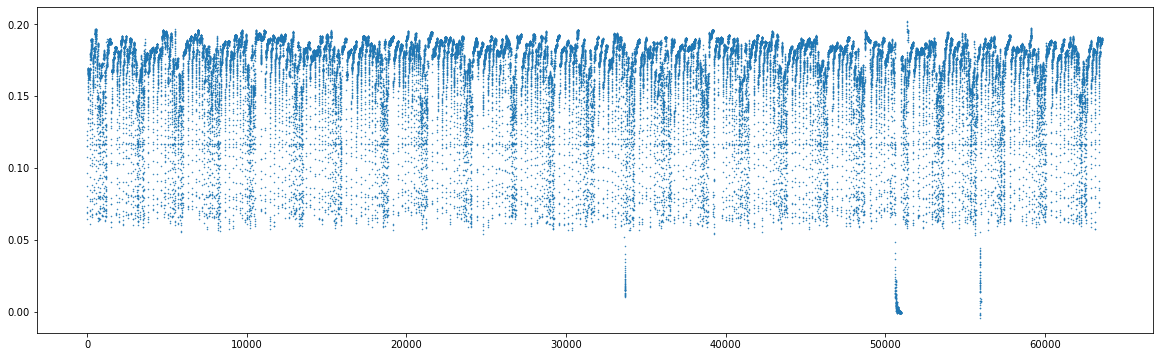

In [181]:
plt.figure(figsize=(20,6))
plt.plot(np.arange(0,len(df)), df['pps'], '.', markersize=1)

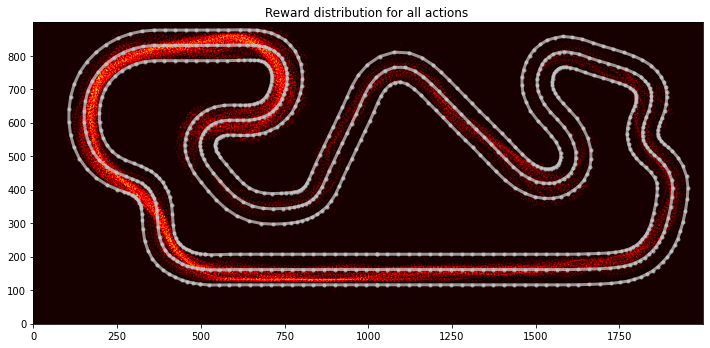

<Figure size 432x288 with 0 Axes>

In [182]:
pu.plot_track(df, track, value_field='pps', margin=1)

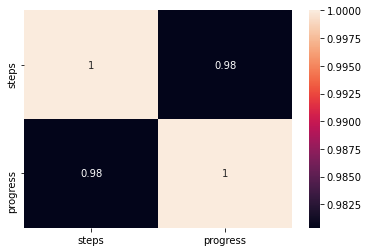

In [183]:
sns.heatmap(df[['steps', 'progress']].corr(), annot=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ff3fb7970>,
      dtype=object)

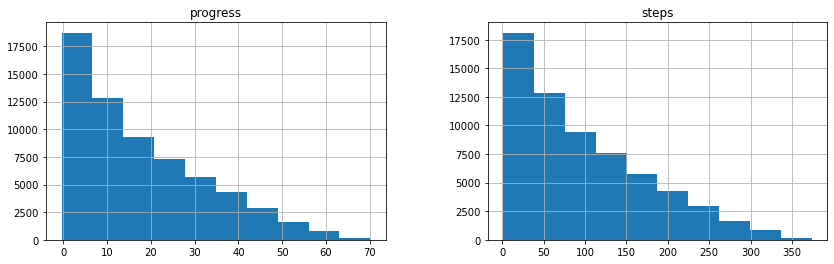

In [184]:
df[['steps', 'progress']].hist(figsize=(14,4))

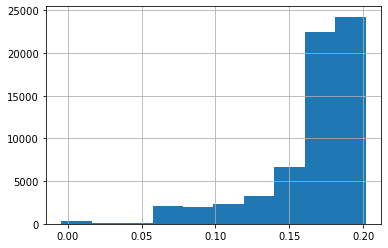

In [185]:
df['pps'].hist()

## Progress and progression tempo
Tempo is the track distance covered in a single step.

> **NOTE** that it is calculated from progress so zig-zag does not count. We care about distance covered towards the finish line.

The higher the value the better progress car is making.

In [186]:
def tempo(progress):
    result = np.zeros(len(progress))
    last = 0.0
    for x in range(0,len(progress)):
        d = 0.0
        p = progress[x] / 100.0
        if last < p:
            d = p - last
        result[x] = d
        last = max(float(p), 0.0)
    return result

In [187]:
# Logarithmic progress for increased contrast (subject to change if a better method of contrast increase is developed)
df['log_progress'] = [math.log(1.0 + r['progress'] / 10.0) for _,r in df.iterrows()]

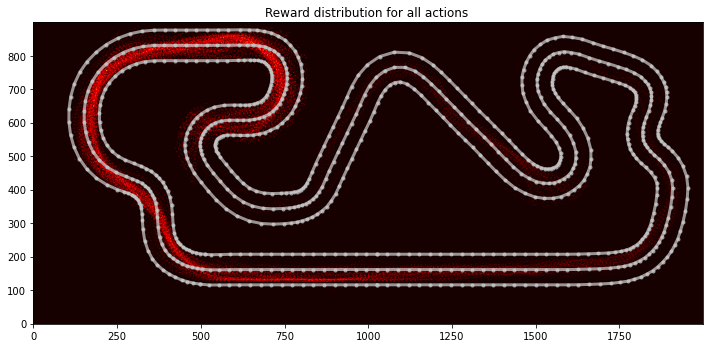

<Figure size 432x288 with 0 Axes>

In [188]:
pu.plot_track(df, track, value_field='log_progress', margin=1)

In [189]:
df['tempo'] = tempo(df['progress']) * df['track_len'][0]

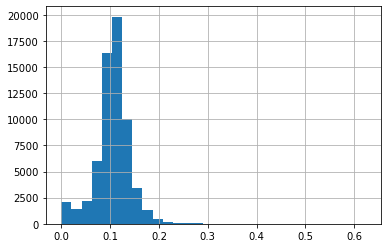

In [190]:
df['tempo'].hist(bins=30)

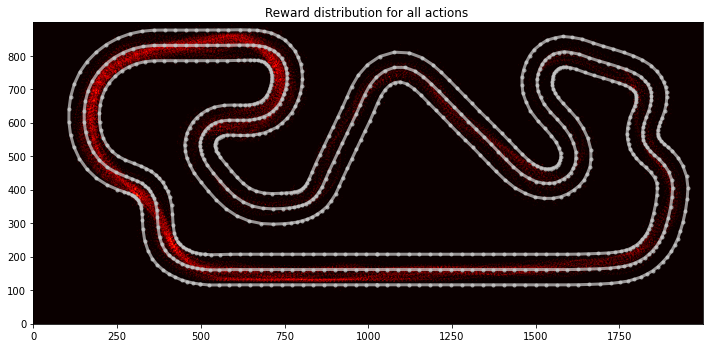

<Figure size 432x288 with 0 Axes>

In [191]:
pu.plot_track(df[df['tempo'] < 0.25], track, value_field='tempo')

# Reward Properties
Analyze returned reward, apply different rewards for comparison.

## Helper definitions

In [192]:
def plot_track(t, fig=None):
    ratio = (lambda x,y: x / y)(*t.size())
    if fig is None:
        fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot()
    ax.axis('equal')
    ax.plot(*t.center_line.T, 'b')
    ax.plot(*t.outer_border.T, 'b')
    ax.plot(*t.inner_border.T, 'b')
    return ax

In [193]:
def df2params(frame, track: Track, mapping=None):
    if mapping is None:
        mapping = {'on_track':'all_wheels_on_track', 'throttle':'speed',
                   'yaw':'heading', 'steer':'steering_angle', 'track_len':'track_length', 'progress':'progress', 'steps':'steps',
                  'x':'x', 'y':'y', 'distance_from_center':'distance_from_center'}
    d = {'closest_waypoints': [frame['closest_waypoint'], (frame['closest_waypoint']+1)%len(track.center_line)]}
    width = np.linalg.norm(track.inner_border[0] - track.outer_border[0])
    d.update({'is_reversed':False, 'waypoints':track.center_line, 'track_width':width})
    d.update({mapping[k]:frame[k] for k in mapping})
    return d

In [194]:
import importlib

### Estimate missing parameters

In [195]:
def dist_from_center(row, waypoints):
    "Adds missing distance_from_center column"
    close = row['closest_waypoint']
    estimated = np.array(waypoints[close])
    pos = np.array([row['x'], row['y']])
    dist = np.linalg.norm(pos - estimated)
    return dist

In [196]:
df['distance_from_center'] = [dist_from_center(r, track.center_line) for _,r in df.iterrows()]

## Apply different reward

In [227]:
name = 'tempo'
reward = importlib.import_module('rewards.{0}'.format(name))
# Reload module so it is always up to date
importlib.reload(reward)
reward_function = reward.reward_function

In [228]:
original = 'reward'
# Recalculate log can be unncessary because we use original value from memory
if 'log_'+original not in df.columns:
    df['log_' + original] = [math.log(1 + r[original]) for _,r in df.iterrows()]

In [ ]:
df[name] = [reward_function(df2params(r, track)) for _,r in df.iterrows()]
df['log_' + name] = [math.log(1 + r[name]) for _,r in df.iterrows()]

In [ ]:
df[[original, name]].hist(figsize=(14,4))
df[[original, name]].hist(figsize=(14,4), bins=60)

In [ ]:
df[[original, name]].describe()

In [ ]:
sample = df.sample(frac=0.75)
#sample = df[df[name] > 1.0]

In [ ]:
pu.plot_track(sample, track, value_field='log_{0}'.format(original))

In [ ]:
pu.plot_track(sample, track, value_field='log_{0}'.format(name))

In [ ]:
plt.figure(figsize=(20,12))

plt.subplot(2,1,1)
plt.plot(df.index, df[original], '.', markersize=1)
plt.title(original)

plt.subplot(2,1,2)
plt.plot(df.index, df[name], '.', markersize=1)
plt.title(name)

# Bonus : Visualize reward

## Compare functions
Choose your warrior wisely. Your function needs improvement? Incorrect distribution? Don't worry! Let's see which function does suit your needs best!

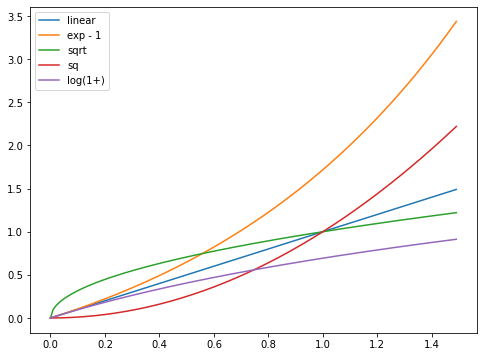

In [195]:
ox = np.arange(0,1.5,0.01)
plt.figure(figsize=(8,6))
plt.plot(ox, ox)
plt.plot(ox, np.exp(ox) - 1)
plt.plot(ox, np.sqrt(ox))
plt.plot(ox, np.power(ox, 2.0))
plt.plot(ox, np.log(1 + ox))
plt.legend(['linear','exp - 1','sqrt','sq','log(1+)'])

## Plot 3d reward distribution

To create a 3d plot we use a sample from our logs and update 2 of its parameters creating a 2d space of inputs. Once that is done we simply iterate over these plane calculating the reward for such parameters combination.

> Z coordinate is the reward result. `jupyter notebook` classical notebook is needed to create interactive plots.

In [ ]:
# Works only with jupyter notebook
%matplotlib notebook

In [44]:
def plot3d_reward(fig, x, y, rewardf):
    "Plot rewardf(x,y) reward to visualize reward resoponse on x,y parameters change"
    X,Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    # ideally array should be passed into the reward, but some rewards use functions from math library, which is incompatible with numpy arrays
    # to solve this problem we calculate reward iteratively
    for r in range(0,Z.shape[0]):
        for c in range(0,Z.shape[1]):
            Z[r,c] = rewardf(X[r,c], Y[r,c])
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X,Y,Z)
    return ax

In [45]:
def updated_params(params, **kwargs):
    p = dict(params)
    p.update(kwargs)
    return p

In [50]:
src = df.sample(n=1)
src

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,...,closest_waypoint,track_len,timestamp,pps,log_progress,tempo,distance_from_center,log_reward,heading,log_heading
8644,9,262,1,-5.7338,-1.8657,152.891,10.0,1.5,4.0,1.0012,...,24,60.0,1590784661.9030929,0.11605,0.022945,0.0,0.023187,0.693747,2.593105,1.279017


In [51]:
params = df2params(src.iloc[0], track)
rew = lambda x, y: reward_function(updated_params(params, distance_from_center=x, heading=y))

In [52]:
X = np.arange(0.0, params['track_width'], 0.01)
Y = np.arange(-180, 180, 0.1)

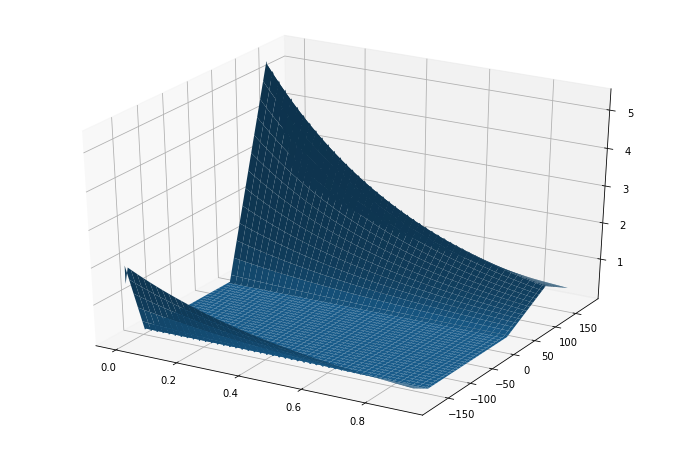

In [53]:
fig = plt.figure(figsize=(12,8))
plot3d_reward(fig, X, Y, rew)

## Plot saved sectors
If your last computed reward function implements sectors global variable storing model records, you can plot it here.

In [46]:
sectors = pd.DataFrame([(a[0],a[1],b) for a,b in reward.sectors.items()], columns=['x', 'y', 'var'])
plt.plot(sectors.index, sectors['var'])

AttributeError: module 'rewards.kvyat' has no attribute 'sectors'

In [64]:
rew(0.0, 120)

5.248811062097708

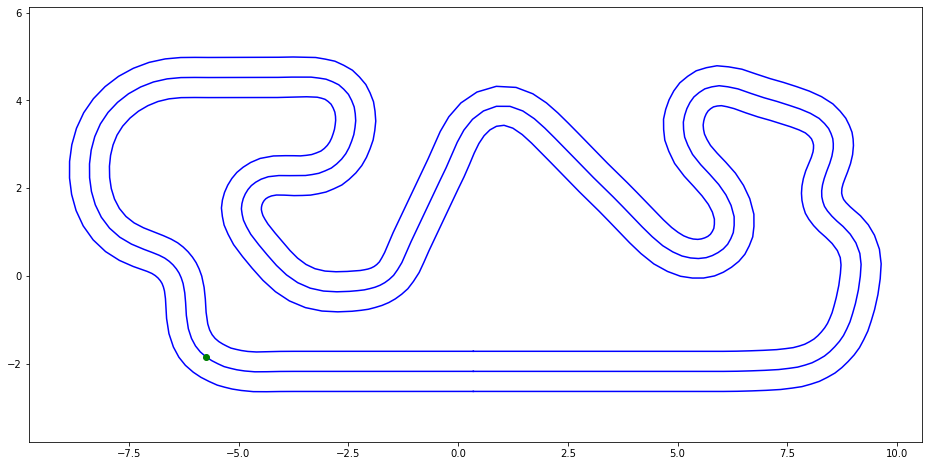

In [119]:
ax = plot_track(track)
ax.plot(*track.center_line[24], 'go')